In [21]:
import torch

In [22]:
import triton
import triton.language as tl

In [ ]:
# --------------------------------------------------
# Triton 加法 Kernel：每个 program 处理 BLOCK_SIZE 个元素
# 与 CUDA C 对比：
#   - Triton kernel 用 @triton.jit 装饰
#   - CUDA C 用 __global__ 关键字
#   - Triton 程序实例 (program) 类似 CUDA Block
#   - Triton 中向量化操作替代 CUDA 中的 threadIdx 和 vector types
# --------------------------------------------------
@triton.jit  # 等价于 CUDA 的 __global__ 修饰符，将函数编译为 GPU kernel
def addKernel(
    x_ptr,            # 指向第一个输入向量的指针（相当于 float* x 在 __global__ 函数中）
    y_ptr,            # 指向第二个输入向量的指针（相当于 float* y）
    o_ptr,            # 指向输出向量的指针（相当于 float* output）
    n_elements,       # 向量总长度（int n），用于边界检查
    BLOCK_SIZE: tl.constexpr  # 每个 Triton program 处理的元素数量，相当于 CUDA 中的 blockDim.x
):
    # --------------------------------------------------
    # 1. 获取 program/block 索引
    # --------------------------------------------------
    # Triton: program_id(axis=0) 获取一维 launch grid 的当前 program 索引
    # CUDA: blockIdx.x
    pid = tl.program_id(axis=0)

    # --------------------------------------------------
    # 2. 计算全局元素索引范围
    # --------------------------------------------------
    # CUDA: 每个线程计算 idx = blockIdx.x * blockDim.x + threadIdx.x
    # Triton: 先计算 block_start = pid * BLOCK_SIZE
    block_start = pid * BLOCK_SIZE
    # 再生成一个长度为 BLOCK_SIZE 的向量 [0,1,2,...,BLOCK_SIZE-1]
    # 并加上 block_start 得到 offsets，相当于一个 block 内所有线程的全局 idx
    offsets = block_start + tl.arange(0, BLOCK_SIZE)

    # --------------------------------------------------
    # 3. 边界检查 (Mask)
    # --------------------------------------------------
    # CUDA: if (idx < n) { ... }
    # Triton: 用布尔向量 masks，后续加载/存储都根据 mask 屏蔽越界访问
    masks = offsets < n_elements

    # --------------------------------------------------
    # 4. 加载数据
    # --------------------------------------------------
    # CUDA: float x_val = x[idx]; float y_val = y[idx];
    # Triton: tl.load 支持向量化加载 BLOCK_SIZE 个元素，mask 屏蔽越界位置
    x = tl.load(x_ptr + offsets, mask=masks)  # 加载 x[offsets]
    y = tl.load(y_ptr + offsets, mask=masks)  # 加载 y[offsets]

    # --------------------------------------------------
    # 5. 执行计算
    # --------------------------------------------------
    # CUDA: float out = x_val + y_val;
    # Triton: 向量加法，一次处理 BLOCK_SIZE 个元素
    result = x + y

    # --------------------------------------------------
    # 6. 存储结果
    # --------------------------------------------------
    # CUDA: output[idx] = out;
    # Triton: tl.store 支持向量化存储，mask 同样屏蔽越界存储
    tl.store(o_ptr + offsets, result, mask=masks)

In [ ]:
def add(x: torch.Tensor, y: torch.Tensor):
    """
    在 Python 侧调用 Triton kernel 的封装函数，与 CUDA 对比：
      - Triton: add(x, y) 返回异步执行的 output
      - CUDA: cudaMalloc + kernel<<<blocks, threads>>>()
    参数：
      x, y    - 位于 CUDA 上的同形状 torch.Tensor
    返回：
      o       - 包含 x+y 结果的 CUDA Tensor
    """
    # ----------------------
    # 1. 分配输出张量
    # ----------------------
    o = torch.empty_like(x)  # 等价于 CUDA malloc(size * sizeof(float))
    # 确保所有张量均在 CUDA 设备上，否则无法传给 GPU
    assert x.is_cuda and y.is_cuda and o.is_cuda, "Tensors must be on CUDA"

    # ----------------------
    # 2. 计算元素总数
    # ----------------------
    # Triton: o.numel() 返回张量总元素数
    # CUDA: 通常在 host 侧计算 n = size
    n_elements = o.numel()

    # ----------------------
    # 3. 定义 launch grid
    # ----------------------
    # Triton: grid 函数接收 meta，返回一维 grid 大小 (num_blocks,)
    #         num_blocks = ceil(n_elements / BLOCK_SIZE)
    # CUDA: <<<num_blocks, blockDim>>>
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']),)

    # ----------------------
    # 4. 启动 Triton kernel
    # ----------------------
    # Triton API: kernel[grid](x, y, o, n_elements, BLOCK_SIZE=1024)
    # CUDA API: addKernel<<<num_blocks, BLOCK_SIZE>>>(x_ptr, y_ptr, o_ptr, n_elements)
    addKernel[grid](
        x,         # 自动转换为指针 x_ptr
        y,         # 自动转换为指针 y_ptr
        o,         # 自动转换为指针 o_ptr
        n_elements,# 传入元素总数，用于 kernel 中边界检查
        BLOCK_SIZE=1024  # 指定每个 Triton program 的处理粒度
    )

    # Triton kernel 在 CUDA stream 上异步执行，如需同步可调用 torch.cuda.synchronize()
    return o


#### 使用 Triton 的 perf_report 装饰器，自动绘制性能曲线

In [25]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],                  # x 轴展示的参数名
        x_vals=[2**i for i in range(12, 28)],  # 不同规模的输入大小（2^12 到 2^27）
        x_log=True,                        # x 轴对数刻度
        line_arg='provider',               # 不同实现用不同线条区分
        line_vals=['triton', 'torch'],     # provider 参数的两个取值
        line_names=['Triton', 'Torch'],    # 两条曲线的图例名称
        styles=[('blue', '-'), ('green', '-')],  # 曲线样式（颜色和线型）
        ylabel='GB/s',                     # y 轴名称
        plot_name='vector-add-performance',# 输出 plot 文件名（png）
        args={},                           # 其他固定参数
    )
)
def benchmark(size, provider):
    x = torch.rand(size, device='cuda', dtype=torch.float32)
    y = torch.rand(size, device='cuda', dtype=torch.float32)
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=[0.5, 0.2, 0.8])
    else:
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y), quantiles=[0.5, 0.2, 0.8])
    n_bytes = 3 * x.numel() * x.element_size()
    gbps = lambda t_ms: n_bytes / t_ms * 1e-6
    return gbps(ms), gbps(max_ms), gbps(min_ms)


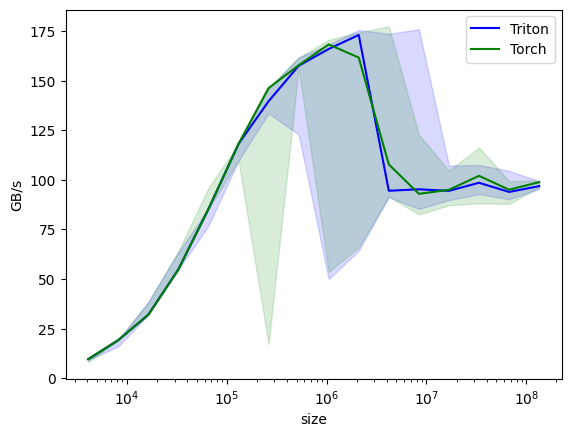

vector-add-performance:
           size      Triton       Torch
0        4096.0    9.600000    9.600000
1        8192.0   19.200000   19.200000
2       16384.0   31.999999   31.999999
3       32768.0   54.857142   54.857142
4       65536.0   85.333330   85.333330
5      131072.0  118.153847  118.153847
6      262144.0  139.636363  146.285715
7      524288.0  157.538467  157.791325
8     1048576.0  166.018992  168.328760
9     2097152.0  173.089468  161.684218
10    4194304.0   94.523077  107.789475
11    8388608.0   95.255814   92.958869
12   16777216.0   94.477654   95.002661
13   33554432.0   98.550373  102.054503
14   67108864.0   93.924761   95.037095
15  134217728.0   96.845273   98.853876


In [26]:
benchmark.run(print_data=True, show_plots=True)